# Mining my own google search history


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re, os
import json
import datetime
import nltk
import itertools
%matplotlib inline

### First, let's define a function to create a pandas dataframe from a single google search history json document. 

Each .json file contains all the queries for a given financial quarter. This function will return a dataframe containing each query along with the timestamp. Unfortunately, it's unclear which queries are from google maps, but direction queries contain a '->', so we'll filter those out.

In [2]:
def readGoogleSearchHistoryJSON(fileName):
    """
    Reads in data from json files provided by google 
    
    param fileName: string of full path to file to load 
    
    return: pandas dataframe containing information 
    """
    
    
    # open file and get raw data 
    fid = open(fileName)
    raw_data = json.load(fid)
    fid.close()

    #initialize 
    queryTimes = []
    queryText = []

    # loop through each query and get data 
    for query in raw_data['event']:
        # get time, and convert to datetime object
        tempTime = datetime.datetime.fromtimestamp(int(query['query']['id'][0]['timestamp_usec'][:10]))

        # get query text
        tempText = query['query']['query_text']
        
        # remove queries with map data 
        if re.search('->', tempText) is not None:
            continue
        
        queryTimes.append(tempTime)
        queryText.append(tempText)

    # create dataframe    
    df = pd.DataFrame(data={'date': queryTimes,'query': queryText})
    return df


### Now that we have our function, let's create dataframes from each file, and concatenate them all together 

In [3]:
""" Import json data """

# set base file path
baseFilePath = '/Users/arimorcos/Databases/Google searches'

# get list of files in path 
fileList = [os.path.join(baseFilePath, file) for file in os.listdir(baseFilePath)]

# get dataframes 
dfList = []
for file in fileList: 
    dfList.append(readGoogleSearchHistoryJSON(file))

# concatenate 
df = pd.concat(dfList, ignore_index=True)

### Let's tokenize each query, and add it as a new column

In [4]:
""" Add tokenized query"""
df['tokenized'] = df['query'].map(lambda words: [word.lower() for word in nltk.word_tokenize(words) if word.isalpha()])

### Now, let's define some helper functions

In [5]:
def getGroupedDate(mode):
    if mode.lower() == 'weekday':
        df.groupby(df['date'].map(lambda date: date.weekday()))
    else:
        return df.groupby(df['date'].map(lambda date: getattr(date, mode)))

In [6]:
def floorToMonth(date):
    return date.replace(day=1, hour=1, minute=1, second=1, microsecond=1)

def floorToDay(date):
    return date.replace(hour=1, minute=1, second=1, microsecond=1)

In [7]:
def countTokWordQuery(series, words, mode='any'):
    """
    Counts the number of queries containing a given word or set of words. 
    
    param series: pandas series containing tokenized queries 
    param words: single string or list of strings to match to each tokenized query
    param mode: options: 'any' or 'all'. Specifies whether all words should match or any words should match. 
    
    return: Number of queries which match the given words
    """
    
    if type(words) is str:
        words = [words]
        
    # convert to lowercase 
    words = [word.lower() for word in words]
    
    if mode == 'any':
        return sum([1 if any([word in item for word in words]) else 0 for item in series.values])
    elif mode == 'all':
        return sum([1 if all([word in item for word in words]) else 0 for item in series.values])

In [8]:
import datetime
def addCopyright(ax, xOffset=0, yOffset=0):
    year = datetime.date.today().year
    if any([i == '_axis3don' for i in dir(ax)]):
        ax.text(0 + xOffset, -.05 + yOffset, 0, r'$\copyright$ Ari Morcos  ' + str(year), transform=ax.transAxes)
    else: 
        ax.text(0 + xOffset, -.05 + yOffset, r'$\copyright$ Ari Morcos  ' + str(year), transform=ax.transAxes)

In [52]:
df.shape

(22339, 3)

# Part I

## Now for the fun part: the actual analysis! 

### We're going to pretend that I don't know anything about myself, so let's first plot the 50 most frequently occurring words in the queries, ignoring common words such as "and" and "or." 

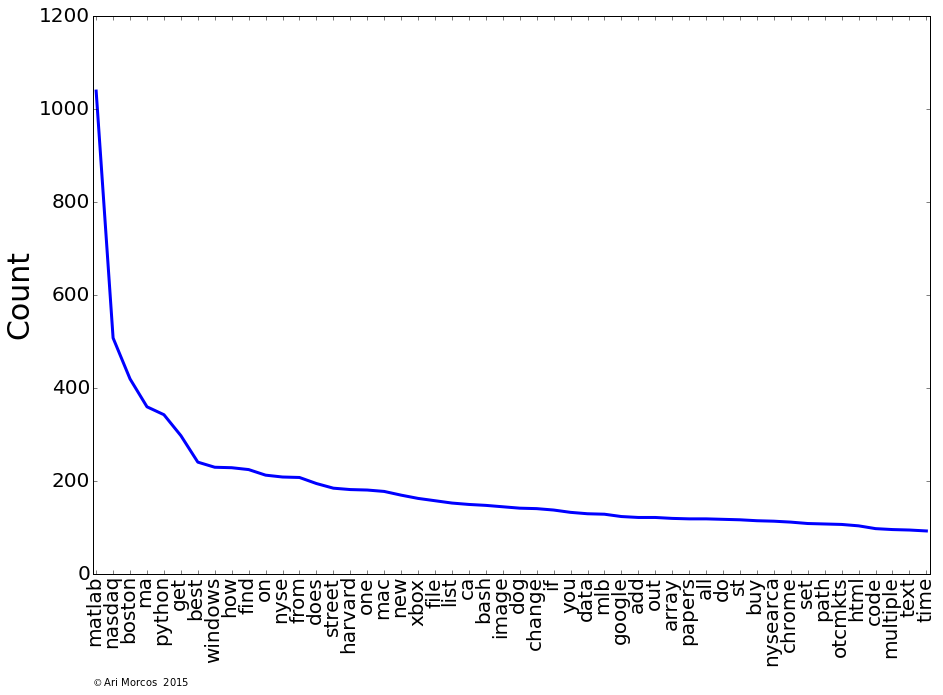

In [32]:
# get concatenated list of words and create frequency distribution 
allWords = list(itertools.chain(*df['tokenized'].values))
commonWords = ['and','to','of','the','not','with','is','a','an','in','for']
allWords = [word for word in allWords if word not in commonWords]
fd = nltk.FreqDist(allWords)

# plot first n values
nWords = 50
fig = plt.figure(figsize=(15,10))
# fd.plot(nWords, cumulative=False)
ax = plt.subplot()
samples = [item for item, _ in fd.most_common(nWords)]
freqs = [fd[sample] for sample in samples]
ax.plot(freqs)
ax.set_xticks(range(len(samples)))
ax.set_xlim(-0.2, len(samples)-0.8)
ax.set_xticklabels(samples, rotation='vertical')
ax.set_ylabel('Count', fontsize=30)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
ax.lines[0].set_lw(3)
# ax.set_xticklabels([label.get_text() for label in ax.get_xticklabels()], rotation=65)
addCopyright(ax, yOffset=-0.15)
# plt.show()
plt.savefig('googleFreqDist.png', transparent=True)

### We can immediately see that I search for terms related to coding, finance, and video games a bunch, and I likely live in Boston.  

### How did searches for these terms change over time? 

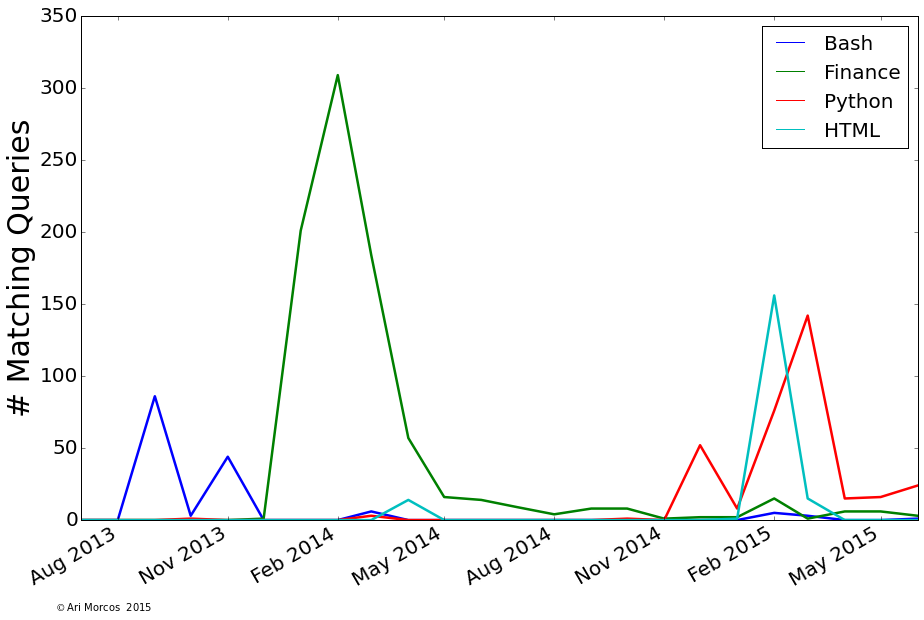

In [49]:
# group by year and month 
g = df.groupby(df['date'].map(floorToMonth))

# plot traces 
# ax = g['tokenized'].apply(countTokWordQuery,['dog','dogs']).plot(fontsize=20);
ax = g['tokenized'].apply(countTokWordQuery,['bash']).plot(fontsize=20);
ax = g['tokenized'].apply(countTokWordQuery,['stock','stocks','finance','nasdaq','nyse']).plot();
ax = g['tokenized'].apply(countTokWordQuery,['python']).plot();
ax = g['tokenized'].apply(countTokWordQuery,['html','css']).plot();
# ax = g['tokenized'].apply(countTokWordQuery,['mlb','baseball']).plot();
# ax = g['tokenized'].apply(countTokWordQuery,['ps4','xbox']).plot();

# add legend 
ax.legend(['Bash','Finance','Python','HTML'], loc=0, fontsize=20)

# set labels 
ax.set_xlabel('')
ax.set_ylabel('# Matching Queries', fontsize=30)

# turn off grid 
ax.grid()

# change linewidth and figsize
[line.set_lw(2.5) for line in ax.lines] # set linewidth 
ax.figure.set_figheight(10); ax.figure.set_figwidth(15)

# add copyright
addCopyright(ax, yOffset=-0.13, xOffset=-0.03)

plt.savefig('projectsCode.png', transparent=True, dpi=200)

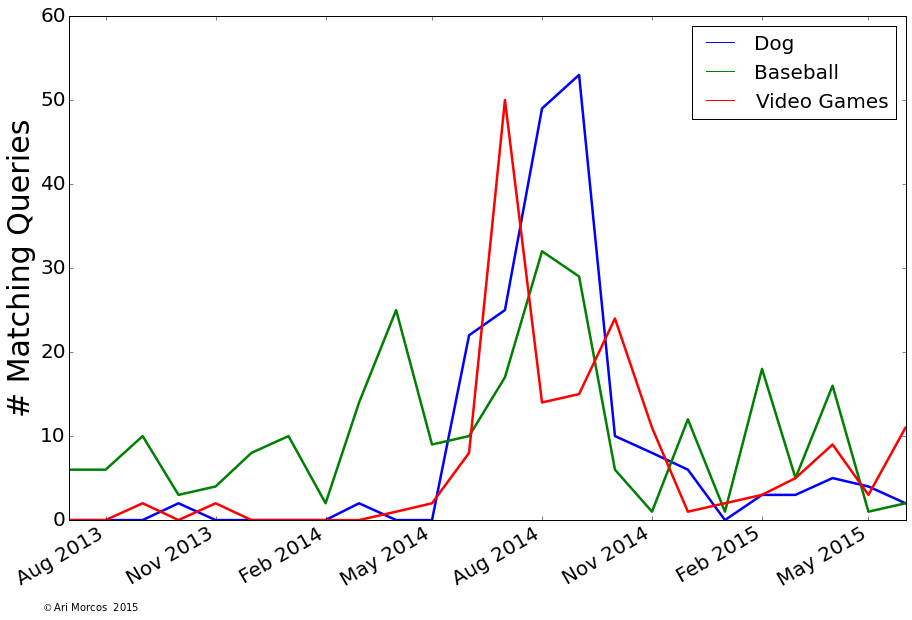

In [50]:
# group by year and month 
g = df.groupby(df['date'].map(floorToMonth))

# plot traces 
ax = g['tokenized'].apply(countTokWordQuery,['dog','dogs']).plot(fontsize=20);
# ax = g['tokenized'].apply(countTokWordQuery,['bash']).plot(fontsize=20);
# ax = g['tokenized'].apply(countTokWordQuery,['stock','stocks','finance','nasdaq','nyse']).plot();
# ax = g['tokenized'].apply(countTokWordQuery,['python']).plot();
# ax = g['tokenized'].apply(countTokWordQuery,['html','css']).plot();
ax = g['tokenized'].apply(countTokWordQuery,['mlb','baseball','angels']).plot();
ax = g['tokenized'].apply(countTokWordQuery,['ps4','xbox']).plot();

# add legend 
ax.legend(['Dog','Baseball','Video Games'], loc=0, fontsize=20)

# set labels 
ax.set_xlabel('')
ax.set_ylabel('# Matching Queries', fontsize=30)

# turn off grid 
ax.grid()

# change linewidth and figsize
[line.set_lw(2.5) for line in ax.lines] # set linewidth 
ax.figure.set_figheight(10); ax.figure.set_figwidth(15)

# add copyright
addCopyright(ax, yOffset=-0.13, xOffset=-0.03)

plt.savefig('projectsCyclical.png', transparent=True, dpi=200)

### How about on a weekly basis? How do my searches for these terms change over the course of a week? For example, when do I search for "matlab" the most? 

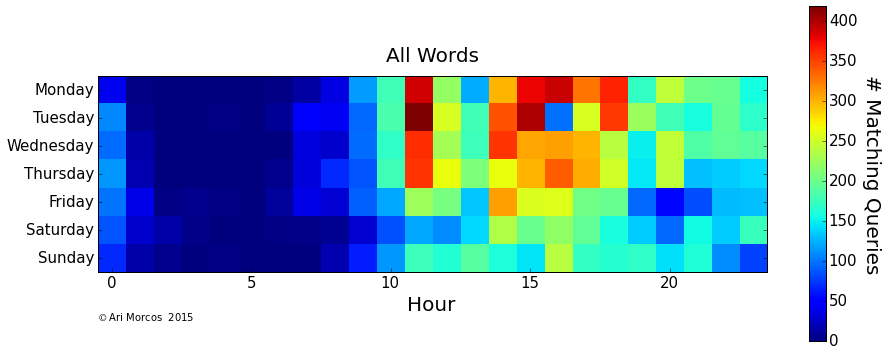

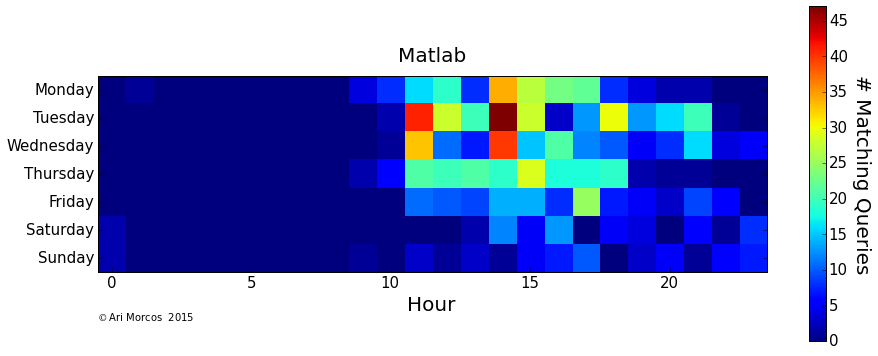

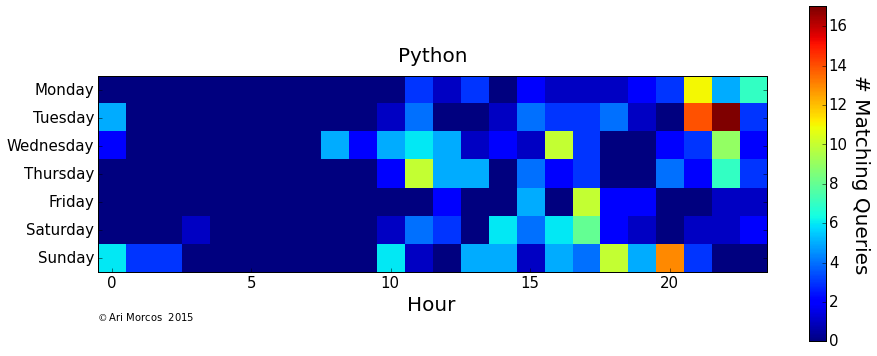

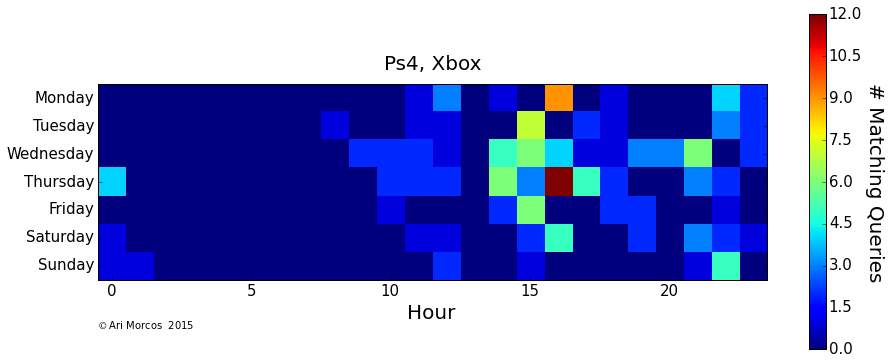

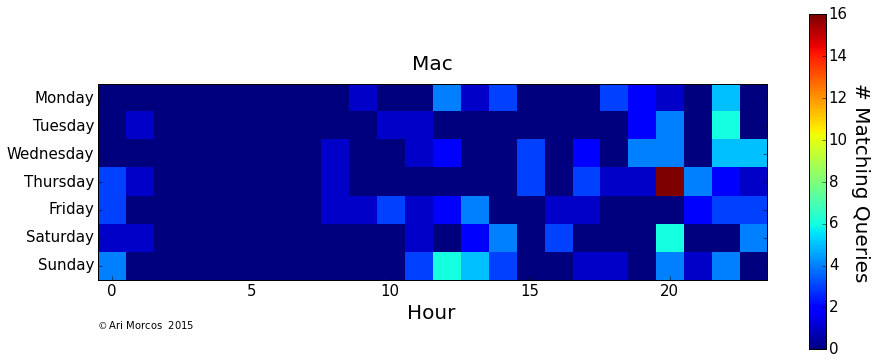

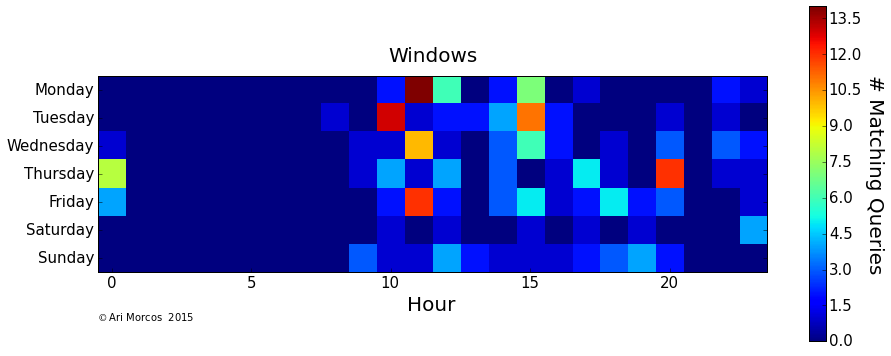

In [51]:
# Define function to plot word usage by weekday and hour 

def plotWordTimeHeatMap(words=None):
    # get series for hours and weekdays 
    hours = df['date'].map(lambda date: date.hour)
    weekdays = df['date'].map(lambda date: date.weekday())

    # group by hours and weekdays
    g = df.groupby([hours,weekdays])

    # take tokenized words, count matches to requested words and unstack 
    if words is None:
        countDF = g['tokenized'].count().unstack(0)
    else:
        countDF = g['tokenized'].apply(countTokWordQuery, words).unstack(0)

    # replace NaN with zero values and extract to numpy array
    countMat = countDF.fillna(0).get_values()

    # plot 
    fig = plt.figure(figsize=(15,15))
    ax = plt.subplot()
    axMat = ax.matshow(countMat)
    
    # set ticks and title
    if type(words) is list:
        ax.set_title(', '.join([word.title() for word in words]))
    elif words is None:
        ax.set_title('All Words')
    else:
        ax.set_title(words.title())
    ax.xaxis.tick_bottom()
    ax.set_xlabel('Hour')
    ax.set_yticks(range(7))
    ax.set_yticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']);
    
    # create colorbar
    cbar = fig.colorbar(axMat, shrink=0.4)
    cbar.set_label('# Matching Queries', fontsize=20, rotation=-90, verticalalignment='bottom')
    cbar.ax.tick_params(labelsize=15)
    
    # change tick size
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(20)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(15)
    
    # add copyright
    addCopyright(ax, yOffset=-0.2)
    
plotWordTimeHeatMap()
# plt.savefig('allWordsHeatmap.png', transparent=True, dpi=200)
plotWordTimeHeatMap('matlab')
# plt.savefig('matlabHeatmap.png', transparent=True, dpi=200)
plotWordTimeHeatMap('python')
# plt.savefig('pythonHeatmap.png', transparent=True, dpi=200)
plotWordTimeHeatMap(['ps4','xbox'])
# plt.savefig('videoGamesHeatmap.png', transparent=True, dpi=200)
plotWordTimeHeatMap('mac')
# plt.savefig('macHeatmap.png', transparent=True, dpi=200)
plotWordTimeHeatMap('windows')
# plt.savefig('windowsHeatmap.png', transparent=True, dpi=200)

# Part II